### Clustering
1. [Objective](#obj)
1. [Module Imports](#import)
1. [My Functions](#def)    
2. [Data](#raw)
4. [Feature](#feat)
4. [Clustering](#cluster)
5. [Scratch](#scratch)



### Objective <a name="obj"></a>

##### Challenge: Boston marathon

You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

#### Module Imports <a name="import"></a>

In [1]:
#basics
import pandas as pd
import numpy as np
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.cluster import AffinityPropagation, KMeans, MiniBatchKMeans
from sklearn import metrics

In [3]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.preprocessing import normalize, OrdinalEncoder

#### My Functions <a name="func"></a>

In [4]:
def fold_shuffle(df, n):
    assert(1 <= n <= len(df))
    ndv = len(df) // n; nrm = len(df) % n 
    df['num'] = range(len(df))
    idx = list(df.index); np.random.shuffle(idx)
    df.index = idx; df.sort_index( axis=0, inplace=True)
    df.index = pd.Series([x for x in range(n)] * ndv + [x for x in range(nrm)])
    dfs = [df[df.index == i] for i in range(n)]
    for df in dfs: df.index = df.num
    return dfs

#### Process Data<a name="data"></a>

In [5]:
# load csv, sort the columns for readibility, 
df = pd.read_csv('data/2014.txt')
#organize the column labels
srt_lbl = ['age', 'name', 'division', 'gender','bib', 'genderdiv', 'overall','city','state', 'ctz', 'country', 
           'official', 'half', 'pace', '5k','10k', '20k','25k','30k', '35k', '40k']
df = df[srt_lbl]
# remove duplicates and non-runners rows
df = df.drop_duplicates()
row_drp = list(np.where(df.bib.str.contains('W', regex=False))[0])
df = df.drop(row_drp)

df.index = range(len(df))
df.tail(2)

,age,name,division,gender,bib,genderdiv,overall,city,state,ctz,...,official,half,pace,5k,10k,20k,25k,30k,35k,40k
31929,38,"Morganthal, Amy",5800,F,35911,12009,27476,North Andover,MA,NaN,...,302.73,137.03,11.55,30.98,63.75,129.90,167.82,207.52,247.18,285.87
31930,54,"Kirchner, Jeffrey T.",1396,M,35912,9771,14844,Lancaster,PA,NaN,...,228.30,114.13,8.72,26.92,53.63,108.03,135.02,161.83,189.68,216.48


In [7]:
fte_cat = ['gender'];  fte_ord = [];  fte_cnt = ['official','age']
fte = fte_cat + fte_ord + fte_cnt
df1 = df[fte]; df1.head(2)

,gender,official,age
0,F,138.95,33
1,F,140.58,24


In [8]:
# Features classified as continous, ordinal and categorical for preprocessing
tfr_cnt = Pipeline(steps=[('siz', SimpleImputer(strategy='constant', fill_value=0)),('ssr', StandardScaler())])
tfr_ord = Pipeline(steps=[('siz', SimpleImputer(strategy='constant', fill_value=0)),('oer', OrdinalEncoder())])
tfr_cat = Pipeline(steps=[('sin', SimpleImputer(strategy='constant', fill_value='nan')),
                          ('ohe', OneHotEncoder(categories='auto'))])

ppr = ColumnTransformer(transformers=[('cnt', tfr_cnt, fte_cnt), ('ord', tfr_ord, fte_ord), ('cat', tfr_cat, fte_cat)]) 

In [9]:
clu_mbk = MiniBatchKMeans(n_clusters=4, random_state=0, batch_size=10)
clu_apn = AffinityPropagation()
clu_kmn = KMeans(n_clusters=7, random_state=42)

In [10]:
#X = df.drop(['num'], axis=1)
pca = PCA(n_components=2).fit_transform(ppr.fit_transform(df1))
dfp = pd.DataFrame(pca, columns=['pc1', 'pc2'])
dfc = pd.DataFrame(clu_kmn.fit_predict(dfp), columns=['cluster']) 
data = pd.concat([dfc, dfp], axis=1)

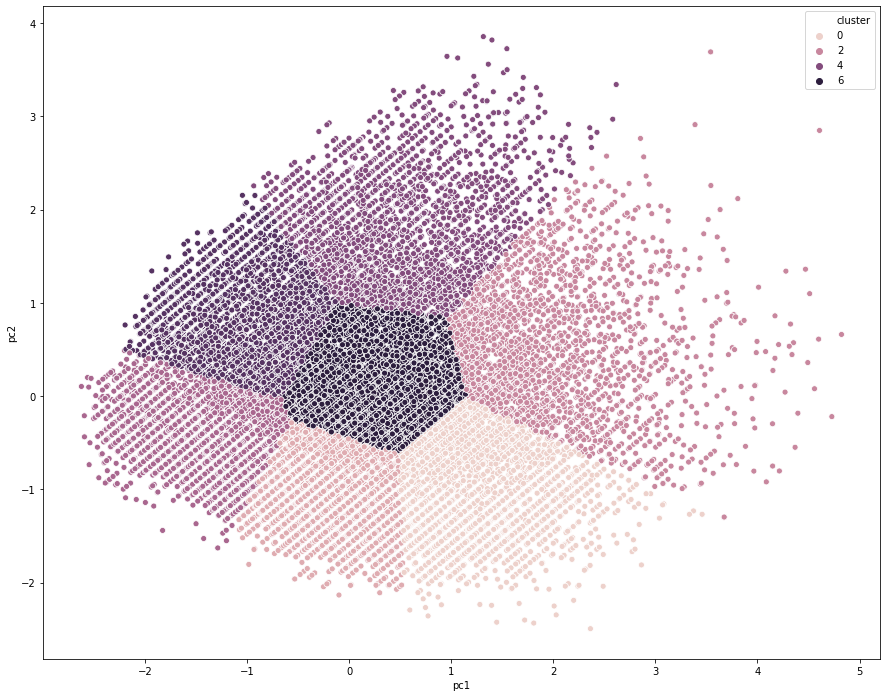

In [69]:
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.scatterplot(x="pc1", y="pc2", hue="cluster", data=data)

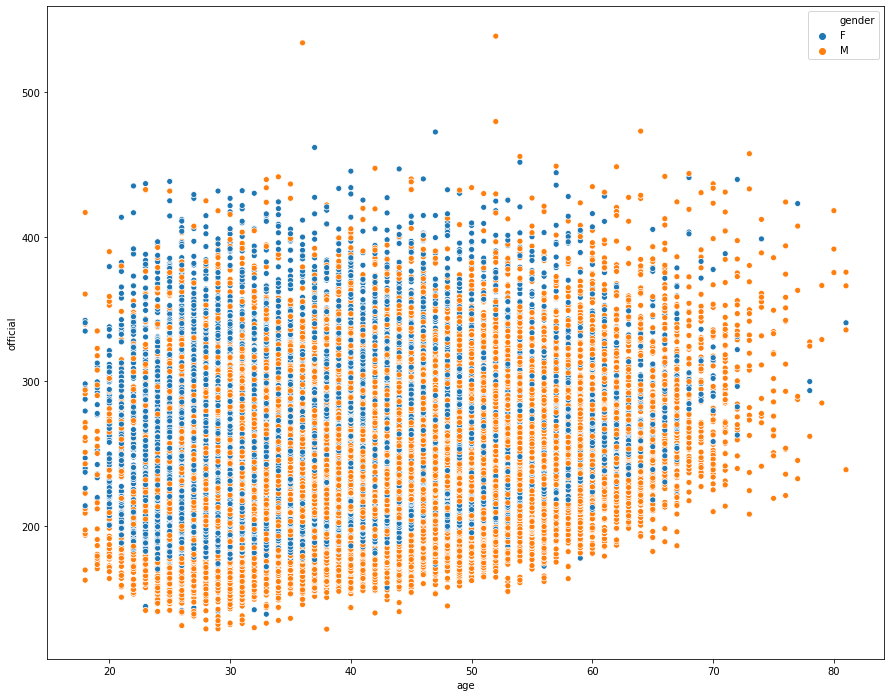

In [20]:
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.scatterplot(x="age", y="official", hue="gender", data=dft)

In [22]:
datp = pd.concat([df1,dfc.cluster], axis=1)
datp.head()

,gender,official,age,cluster
0,F,138.95,33,3
1,F,140.58,24,3
2,F,140.68,29,3
3,M,129.83,29,3
4,M,137.83,31,3


In [12]:
dft = pd.concat([df,dfc.cluster], axis=1)
dft.head()

,age,name,division,gender,bib,genderdiv,overall,city,state,ctz,...,half,pace,5k,10k,20k,25k,30k,35k,40k,cluster
0,33,"Jeptoo, Rita",1,F,F1,1,21,Eldoret,NaN,NaN,...,69.47,5.30,16.22,32.58,65.83,82.43,99.33,116.37,132.10,3
1,24,"Dibaba, Mare",3,F,F2,3,27,Shoa,NaN,NaN,...,69.47,5.37,16.20,32.57,65.83,82.43,99.33,116.37,132.95,3
2,29,"Sumgong, Jemima Jelagat",4,F,F3,4,28,Nandi,NaN,NaN,...,69.47,5.37,16.22,32.58,65.83,82.45,99.33,116.37,132.95,3
3,29,"Geneti, Markos",5,M,5,5,5,Addis Ababa,NaN,NaN,...,64.85,4.97,15.17,30.48,61.62,76.95,92.52,107.47,122.80,3
4,31,"Hall, Ryan",20,M,6,20,20,Redding,CA,NaN,...,65.23,5.27,15.15,30.48,61.78,77.68,94.78,112.27,129.83,3


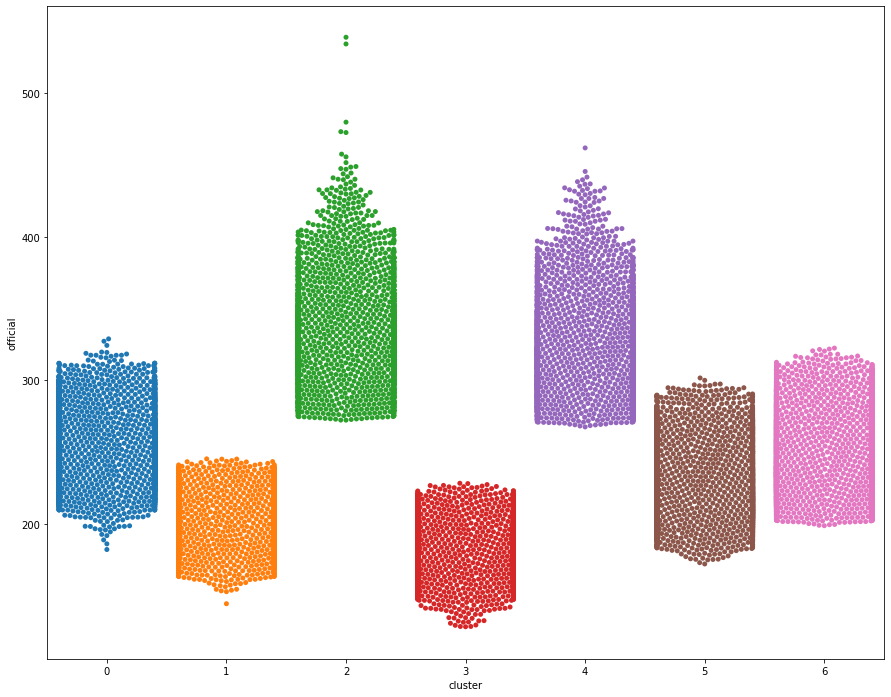

In [13]:
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.swarmplot(x="cluster", y="official", data=dft)

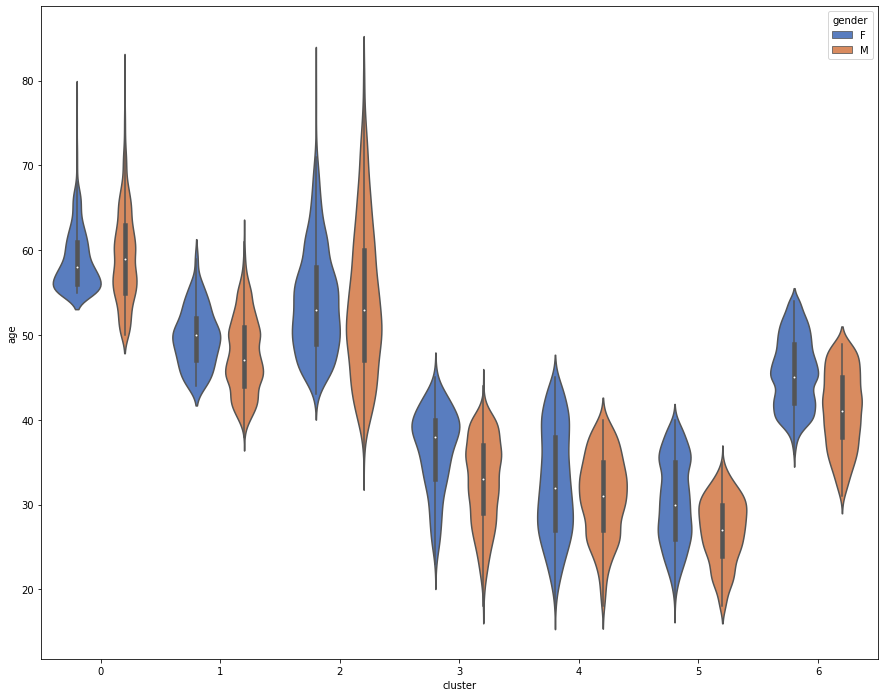

In [29]:
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.violinplot(x="cluster", y="age", hue="gender",  data=dft, palette="muted")

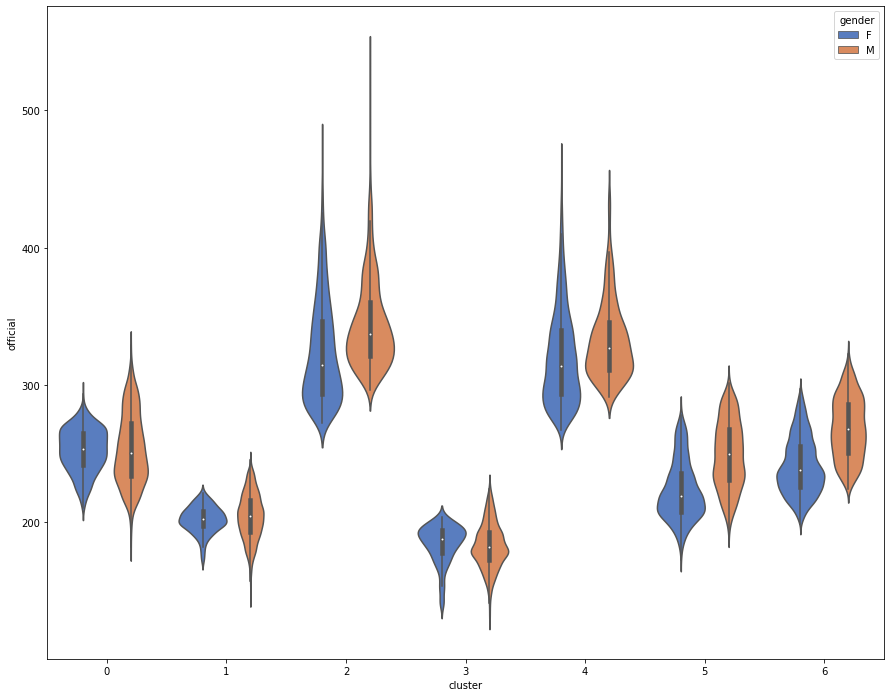

In [19]:
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.violinplot(x="cluster", y="official", hue="gender",  data=dft, palette="muted")

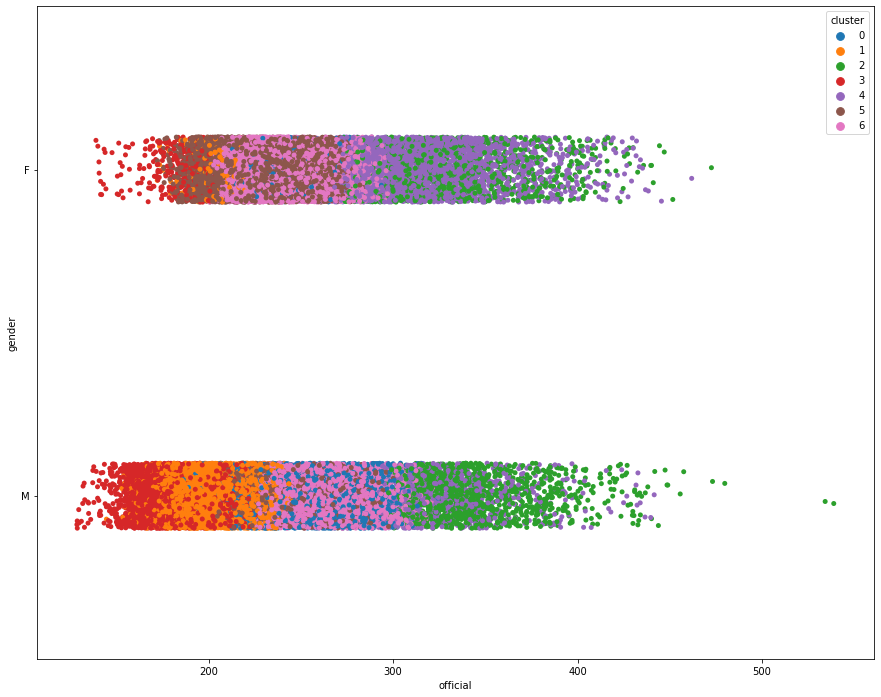

In [17]:
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.stripplot(x="official", y="gender", hue="cluster", data=dft, jitter=True)

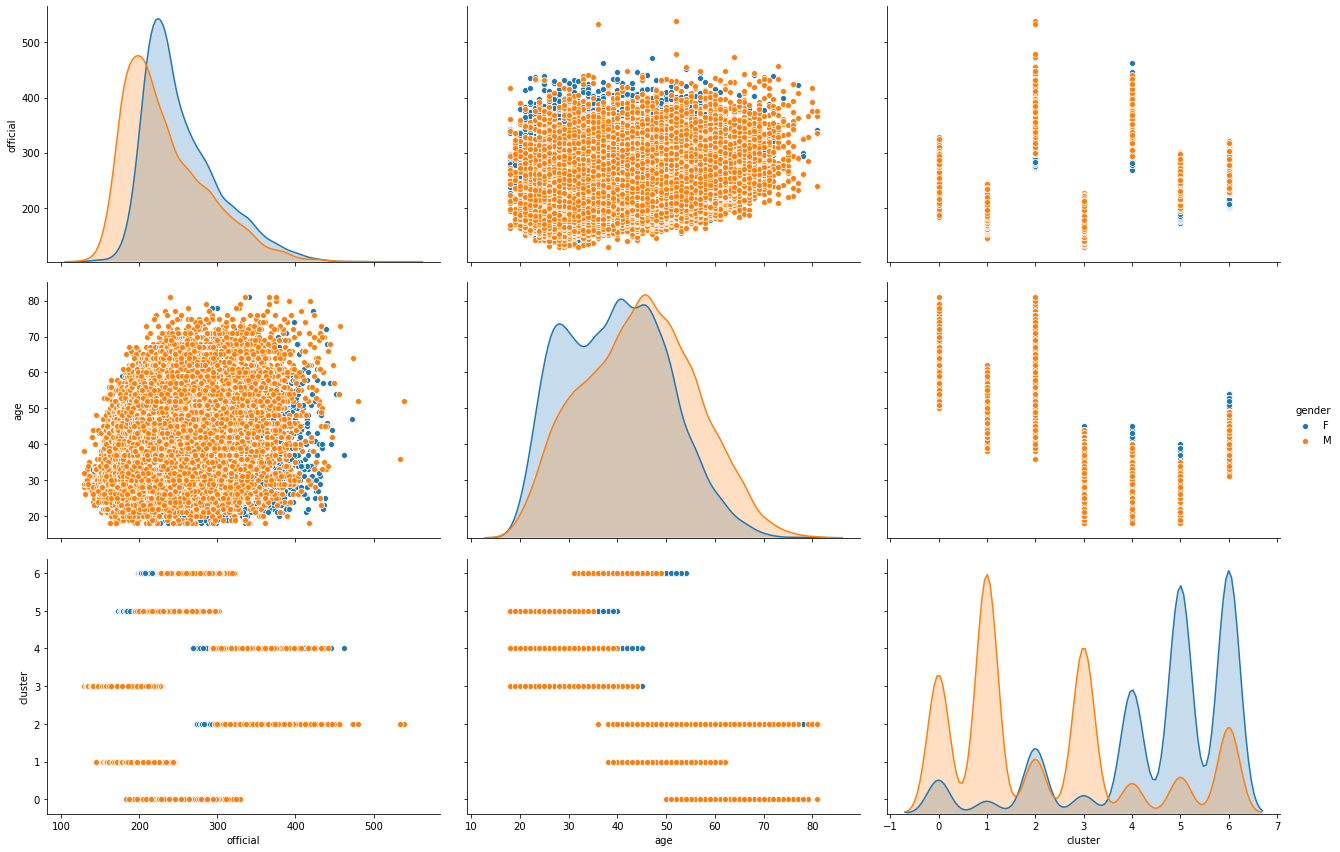

In [28]:
g = sns.pairplot(datp,height=4, aspect=1.5, hue="gender")

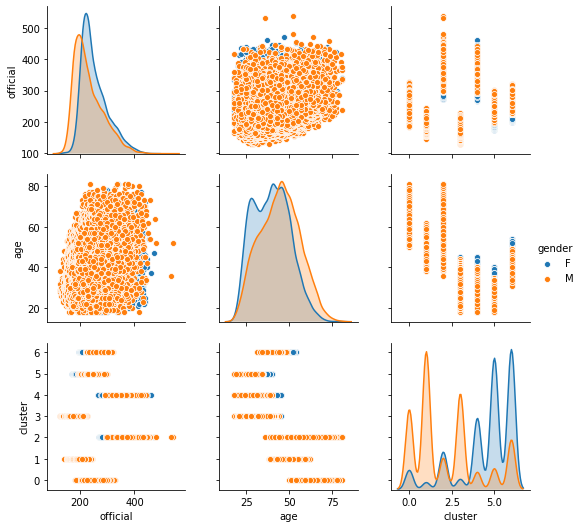

In [24]:
g = sns.pairplot(datp, hue="gender")

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.stripplot(x="official", y="cluster", hue="gender", data=dft, jitter=True)

In [75]:
df['cluster'] = data.cluster
df.head()

,age,name,division,gender,bib,genderdiv,overall,city,state,ctz,...,half,pace,5k,10k,20k,25k,30k,35k,40k,cluster
0,33,"Jeptoo, Rita",1,F,F1,1,21,Eldoret,NaN,NaN,...,69.47,5.30,16.22,32.58,65.83,82.43,99.33,116.37,132.10,3
1,24,"Dibaba, Mare",3,F,F2,3,27,Shoa,NaN,NaN,...,69.47,5.37,16.20,32.57,65.83,82.43,99.33,116.37,132.95,3
2,29,"Sumgong, Jemima Jelagat",4,F,F3,4,28,Nandi,NaN,NaN,...,69.47,5.37,16.22,32.58,65.83,82.45,99.33,116.37,132.95,3
3,29,"Geneti, Markos",5,M,5,5,5,Addis Ababa,NaN,NaN,...,64.85,4.97,15.17,30.48,61.62,76.95,92.52,107.47,122.80,3
4,31,"Hall, Ryan",20,M,6,20,20,Redding,CA,NaN,...,65.23,5.27,15.15,30.48,61.78,77.68,94.78,112.27,129.83,3


In [79]:
df.groupby('cluster')

,age,name,division,gender,bib,genderdiv,overall,city,state,ctz,...,half,pace,5k,10k,20k,25k,30k,35k,40k,cluster
0,33,"Jeptoo, Rita",1,F,F1,1,21,Eldoret,NaN,NaN,...,69.47,5.30,16.22,32.58,65.83,82.43,99.33,116.37,132.10,3
1,24,"Dibaba, Mare",3,F,F2,3,27,Shoa,NaN,NaN,...,69.47,5.37,16.20,32.57,65.83,82.43,99.33,116.37,132.95,3
2,29,"Sumgong, Jemima Jelagat",4,F,F3,4,28,Nandi,NaN,NaN,...,69.47,5.37,16.22,32.58,65.83,82.45,99.33,116.37,132.95,3
3,29,"Geneti, Markos",5,M,5,5,5,Addis Ababa,NaN,NaN,...,64.85,4.97,15.17,30.48,61.62,76.95,92.52,107.47,122.80,3
4,31,"Hall, Ryan",20,M,6,20,20,Redding,CA,NaN,...,65.23,5.27,15.15,30.48,61.78,77.68,94.78,112.27,129.83,3
70,41,"Troop, Lee",982,M,75,5000,5710,Boulder,CO,AUS,...,68.73,7.53,15.68,32.12,65.15,82.23,109.23,143.88,183.08,1
73,48,"Lokken, Tracy",1,M,79,40,51,Marquette,MI,NaN,...,70.32,5.53,16.23,32.63,66.53,83.90,101.33,119.20,136.83,1
74,42,"Forsyth, Ian",255,M,81,1753,1853,Ann Arbor,MI,CAN,...,73.08,6.78,16.75,33.78,69.00,88.07,109.23,132.62,167.30,1
95,46,"Wiltse, Paula",3,F,F110,70,1283,Brockville,ON,NaN,...,85.90,6.62,19.53,39.70,81.42,101.90,122.73,144.00,164.38,1
106,59,"Kennedy, Christine B.",2,F,F118,103,1904,Los Gatos,CA,NaN,...,86.37,6.78,19.65,40.17,81.80,102.68,124.22,146.17,167.63,1


In [ ]:
df.groupby('cluster').age.mean()

In [ ]:
# create 4 x DataFrames with 2 PCA features to cluster
dfs = fold_shuffle(df1, 4)
dps = []
for df in dfs:
    X = df.drop(['num'], axis=1)
    pca = PCA(n_components=2).fit_transform(ppr.fit_transform(X))
    dps.append(pd.DataFrame(pca, columns=['pc1', 'pc2'], index=X.index))

In [77]:

dcs = [pd.DataFrame(clu_apn.fit_predict(dp), columns=['cluster'], index = dp.index) for dp in dps]
datas = [pd.concat([dcs[i], dps[i]], axis=1) for i in range(4)]

In [14]:

dcs = [pd.DataFrame(clu_kmn.fit_predict(dp), columns=['cluster'], index = dp.index) for dp in dps]
datas = [pd.concat([dcs[i], dps[i]], axis=1) for i in range(4)]

In [21]:

dcs = [pd.DataFrame(clu_mbk.fit_predict(dp), columns=['cluster'], index = dp.index) for dp in dps]
datas = [pd.concat([dcs[i], dps[i]], axis=1) for i in range(4)]

In [31]:
dcs[0].tail()

,cluster
num,
6248,3
12557,1
16765,2
12125,1
11571,3


In [23]:
dfc = pd.concat(dcs,axis=0)
dfc.tail()

,cluster
num,
21388,0
26440,0
31234,3
26917,0
21018,3


In [24]:
len(dfc)

31931

In [ ]:
idx = 0
fig = plt.figure(1, (16, 16))
for data in datas:
    idx += 1
    plt.subplot(2, 2, idx)
    sns.scatterplot(x="pc1", y="pc2", hue="cluster", data=data, hue_order = [0,1,2,3], 
                    palette='coolwarm' )
plt.show()

### Clustering <a name="cluster"></a>

In [ ]:
# This counter is just to make sure the kernel didn't hang.
if i % 50 == 0:
    print("Processing row {}".format(i))

In [ ]:
clu_scg = SpectralClustering(n_clusters=4, random_state=0)
dcs = [pd.DataFrame(clu_scg.fit_predict(dp), columns=['cluster'], index = dp.index) for dp in dps]
datas = [pd.concat([dcs[i], dps[i]], axis=1) for i in range(4)]

C:\Users\chuck\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [ ]:
clu_apn = AffinityPropagation()
dfc = pd.DataFrame(clu_apn.fit_predict(X), columns=['cluster'])
data = pd.concat([df2, dfc, dfp], axis=1)
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.scatterplot(x="pc1", y="pc2", hue="cluster", data=data)

In [ ]:
dfc = pd.DataFrame(clu_scg.fit_predict(X), columns=['cluster'])

In [ ]:
data = pd.concat([df1, dfc, dfp], axis=1)

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.scatterplot(x="pc1", y="pc2", hue="cluster", data=data)
plt.show()

In [ ]:
bwh = estimate_bandwidth(X)
clu_mst = MeanShift(bandwidth=bwh, bin_seeding=True)
dfc = pd.DataFrame(clu_scg.fit_predict(X), columns=['cluster'])
data = pd.concat([df2, dfc, dfp], axis=1)
f, ax = plt.subplots(1, 1, figsize=(15, 12), sharex=False)
ax = sns.scatterplot(x="pc1", y="pc2", hue="cluster", data=data)

#### Scratch   <a name="scratch"></a>

In [ ]:
df.dtypes

In [ ]:
df.isna().any()

In [ ]:
# evaluate consistency with shuffled 4 fold
Xs = [ppr.fit_transform(x) for x in fold_shuffle(df2, 4)]
df2.index = range(len(df2))